In [1]:
##Import all packages
from __future__ import print_function
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from numpy import zeros, arange
from scipy.integrate import odeint
from math import pi, log10, e, log
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#import pandas as pd

# Conversion factors
LCGS = 1.476701332464468e+05 

In [2]:
# Equation of state that returns density based on the pressure using logarithmic scale
def eos_log(p, logK=np.log10(100.), Gamma=2.):
    if p <= 0:
        return None
    log_rho = (np.log10(p) - logK) / Gamma
    rho = 10**log_rho
    ene = rho + p / (Gamma - 1)
    cs2 = 10**logK * Gamma * (Gamma - 1) / (Gamma - 1 + 10**logK * Gamma * rho**(Gamma - 1)) * rho**(Gamma - 1)
    return rho, ene, cs2

In [3]:
def EOS_r2pe_log(rho, logK=np.log10(100.), Gamma=2.):
    """
    Equation of state (EOS)
    Given rest-mass density, return energy density and pressure
    Polytropic EOS: logP = logK + Gamma logρ
    """
    log_p = logK + Gamma * np.log10(rho)
    p = 10**log_p
    e = rho + p / (Gamma - 1)
    return p, e

In [4]:
# Completes the TOV equations
def tov_log(t, y):
    """
    Tolmann-Oppenheimer-Volkhoff equations
    d/dt y(t) = R.H.S. 
    """
    r = t
    m = y[0]  # mass of a sphere of radius r
    p = y[1]  # pressure
    result = eos_log(p)
    if result is None:
        return np.array([0.0, 0.0])
    rho, ene, _ = result
    dy = np.empty_like(y)
    dy[0] = 4 * np.pi * ene * r**2
    dy[1] = -(ene + p) * (m + 4 * np.pi * r**3 * p) / (r * (r - 2 * m))
    return dy

def found_radius_log(t, y, pfloor=0.):
    """
    Event function: Zero of pressure 
    ODE integration stops when this function returns True
    """
    return ((y[1] - pfloor) <= 0.)

In [5]:
def solve_ode_euler_log(t, y0, dydt_fun, stop_event=None, verbose=False):
    """
    Euler algorithm 
    NOTE: solution is not stored/saved, just return last point
    """
    N = len(t)
    dt = np.diff(t)[0]  # assume a uniformly spaced t array
    y = y0
    for i in range(N):
        yprev = np.copy(y)  # store previous for returning pre-event data
        y += dt * dydt_fun(t[i], y)
        if verbose:
            print(t[i], y)
        if stop_event:
            if bool(stop_event(t[i], y)):
                print("Event reached.")
                return t[i-1], yprev
    if stop_event:
        print("No event reached")
    return t[i], y

In [6]:
rmin, rmax = 1.28e-3, 24.
N = 100  # number of points between rmin and rmax
rspan = np.linspace(rmin, rmax, N)

In [7]:
rho0 = 1.28e-3  # Central (maximal) rest-mass density
p0, e0 = EOS_r2pe_log(rho0)
m0 = 4. / 3. * np.pi * e0 * rmin**3
sol0 = [m0, p0]

In [8]:

# Integrates the system of differential equations
# and calculates the maximum stable mass and radius based on pressure
t = ''
sol = ''
def tovSolve(pres, sP, bP, pie, sG, bG):
    global minP
    global maxP
    global pieces
    global gammaMin
    global gammaMax
    global t
    global sol

    minP = sP
    maxP = bP
    pieces = pie
    gammaMin = sG
    gammaMax = bG

    pressureCutoff = 1e-13 * pres

    startingRadius = 1e-5
    finalRadius = 4
    step = 0.0001

    t, sol = solve_ode_euler_log(rspan, sol0, tov_log, stop_event=found_radius_log, verbose=True)

    radii = np.arange(startingRadius, finalRadius, step)
    masses = sol[:, 0]
    pressures = sol[:, 1]

    count = 0
    mass = 0.0
    radius = startingRadius

    for i in pressures:
        if i > pressureCutoff:
            count += 1
    radius = (count - 1) * step
    mass = masses[count - 1]

    # Get mass and radius
    R = t * 1.476701332464468e5 * 1.28e-5  # km
    M = sol[0]  # Msun
    pmin = sol[1]
    print(pmin, R, M)

    return radius, mass

In [9]:
def set_initial_conditions_log(rho, rmin):
    """
    Utility routine to set initial data, given rho0
    """
    p, e = EOS_r2pe_log(rho)
    m = 4. / 3. * np.pi * e * rmin**3
    return m, p

In [10]:
# Let us increase the resolution to have better data
N = 1000  # number of points between rmin and rmax
rspan = np.linspace(rmin, rmax, N)

rhospan = np.linspace(0.6e-4, 7e-3, 200)
R = []
M = []

for rho0 in rhospan:
    sol0 = set_initial_conditions_log(rho0, rmin)
    t, sol = solve_ode_euler_log(rspan, sol0, tov_log, stop_event=found_radius_log)
    R.append(t)
    M.append(sol[0])

M = np.array(M)
R = np.array(R)

Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reached.
Event reac

In [11]:
# Find index of maximum mass star
immax = np.argmax(M)
Mmax = M[immax]
Rmax = R[immax]
print(immax, Mmax, Rmax)

88 1.6334724037528339 7.544421221221222


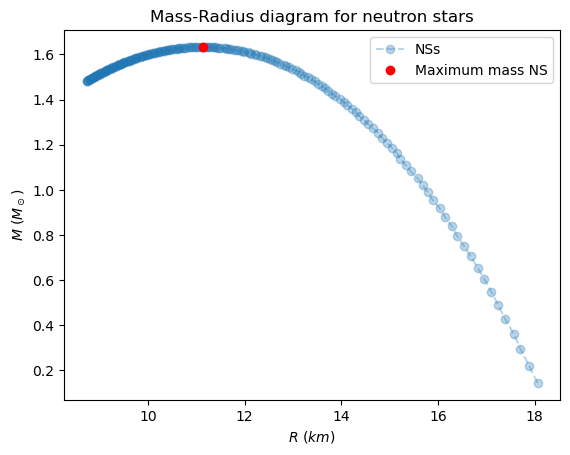

In [12]:
km = 1.476701332464468e5 * 1e-5
fig = plt.figure()
ax = plt.subplot(111)
plt.title('Mass-Radius diagram for neutron stars')
plt.plot(R * km, M, 'o--', label='NSs', alpha=0.3)
plt.plot(Rmax * km, Mmax, 'ro', label='Maximum mass NS')
ax.legend()
plt.xlabel('$R$ $(km)$')
plt.ylabel('$M$ $(M_\odot)$')
fig.savefig('TOV_log.png')
plt.show()

In [13]:
def pressure_piecewise_log(rho, logK1=np.log10(100.), Gamma1=2., logK2=np.log10(50.), Gamma2=2.5, rho_transition=5e-3):
    """
    Given density, return pressure based on piecewise polytropic EoS.
    Units:
    - rho: g/cm^3
    - K1, K2: dyn/cm^2 / (g/cm^3)^Gamma
    - p: dyn/cm^2
    - ene: energy density (arbitrary units)
    - cs2: sound speed squared (cm^2/s^2)
    """
    if rho < rho_transition:
        #print(rho,"if")
        log_p = logK1 + Gamma1 * np.log10(rho)
        p = 10**log_p
        ene = rho + p / (Gamma1 - 1.)
        cs2 = 10**logK1 * Gamma1 * (Gamma1 - 1) / (Gamma1 - 1 + 10**logK1 * Gamma1 * rho**(Gamma1 - 1)) * rho**(Gamma1 - 1)
    else:
        #print(rho, "else")
        log_p = logK2 + Gamma2 * np.log10(rho)
        p = 10**log_p
        ene = rho + p / (Gamma2 - 1.)
        cs2 = 10**logK2 * Gamma2 * (Gamma2 - 1) / (Gamma2 - 1 + 10**logK2 * Gamma2 * rho**(Gamma2 - 1)) * rho**(Gamma2 - 1)
    return p, ene, cs2

# Example usage
rho_example1 = 1e-4  # Example density in region 1 (g/cm^3)
rho_example2 = 1e-2  # Example density in region 2 (g/cm^3)

p1 = pressure_piecewise_log(rho_example1)
p2 = pressure_piecewise_log(rho_example2)

print(f"Pressure, energy density, and sound speed squared for rho={rho_example1} g/cm^3: {p1}")
print(f"Pressure, energy density, and sound speed squared for rho={rho_example2} g/cm^3: {p2}")

# Generate data for plotting
rho_values = np.logspace(-6, -2, 100)  # Density range for plotting (g/cm^3)
#print(type(rho_values))
log_rho_values = np.log10(rho_values)
log_p_values = [np.log10(pressure_piecewise_log(rho)[0]) for rho in rho_values]

#for i in range(len(rho_values)):
#    print(rho_values[i], log_rho_values[i], log_p_values[i])

# Plot pressure versus density on a log-log scale
plt.figure()
plt.plot(log_rho_values, log_p_values, label='Piecewise Polytrope EOS')
plt.xlabel('Log Density ($\\log(\\rho)$) [log(g/cm$^3$)]')
plt.ylabel('Log Pressure ($\\log(P)$) [log(dyn/cm$^2$)]')
plt.title('Log Pressure vs. Log Density for Piecewise Polytrope EOS')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig('log_pressure_vs_log_density_piecewise_log.png')
plt.show()

Pressure, energy density, and sound speed squared for rho=0.0001 g/cm^3: (1e-06, 0.000101, 0.0196078431372549)
Pressure, energy density, and sound speed squared for rho=0.01 g/cm^3: (0.0004999999999999999, 0.010333333333333333, 0.11538461538461538)


NameError: name 'log_rho_values' is not defined

<Figure size 640x480 with 0 Axes>